In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from model_config import ModelConfig
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2022-02-28 13:39:42.457535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-28 13:39:42.457579: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
learning_rate = 0.1

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)
vax_statuses = [Vax.yes, Vax.no]
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
x_test = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)


y_train = {}
y_train['G_in'] = tf.cast(df.loc[train_start:train_end,'general_ward_in'], dtype=tf.float32)
y_train['G_count'] = tf.cast(df.loc[train_start:train_end,'general_ward_count'], dtype=tf.float32)
y_train['I_count'] = tf.cast(df.loc[train_start:train_end,'icu_count'], dtype=tf.float32)
y_train['D_in'] = tf.cast(df.loc[train_start:train_end,'deaths_covid'], dtype=tf.float32) + 1

y_test = {}
y_test['G_in'] = tf.cast(df.loc[train_start:test_end,'general_ward_in'], dtype=tf.float32)
y_test['G_count'] = tf.cast(df.loc[train_start:test_end,'general_ward_count'], dtype=tf.float32)
y_test['I_count'] = tf.cast(df.loc[train_start:test_end,'icu_count'], dtype=tf.float32)
y_test['D_in'] = tf.cast(df.loc[train_start:test_end,'deaths_covid'], dtype=tf.float32)

2022-02-28 13:39:44.783985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-28 13:39:44.784227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-28 13:39:44.784267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-28 13:39:44.784300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-28 13:39:44.784330: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [14]:
config = ModelConfig.from_json("/mnt/c/Users/kheut/Downloads/fix_after_600.json")

In [15]:
model = CovidModel([Vax.no, Vax.yes], [Comp.A, Comp.M, Comp.G, Comp.GR, Comp.I, Comp.IR, Comp.D],
                 transition_window,
                config, posterior_samples=1000, debug_disable_theta=False)

pre_training_preds=model.call(x_train)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1092, in __call__
    return outputs  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 148, in error_handler
    del bound_signature  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 77, in call
    self._sample_and_reparameterize()  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 1204, in _sample_and_reparameterize
    [dist.log_prob(j + 1) for dist in poisson_G_dist_samples]) /  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_functio

In [16]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,#beta_1=0.1, beta_2=0.1
)
#loss((y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in']), pre_training_preds)

In [17]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/linear_warm_fixed_loss_2')

In [18]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]),
         epochs=2000, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/2000
G count: -196.97860717773438
G in: -9.278692245483398
I count: -169.73448181152344
D in: -6.396087169647217
1/1 [==============================] - 45s 45s/step - loss: 1106.3999
Epoch 2/2000
G count: -130.90406799316406
G in: -13.67539119720459
I count: -135.61419677734375
D in: -5.391920566558838
1/1 [==============================] - 44s 44s/step - loss: 940.6477
Epoch 3/2000


KeyboardInterrupt: 

In [ ]:
model.variables

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1092, in __call__
    return outputs  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 148, in error_handler
    del bound_signature  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 77, in call
    self._sample_and_reparameterize()  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 1204, in _sample_and_reparameterize
    [dist.log_prob(j + 1) for dist in poisson_G_dist_samples]) /  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_functio

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1092, in __call__
    return outputs  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 148, in error_handler
    del bound_signature  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 77, in call
    self._sample_and_reparameterize()  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 1200, in _sample_and_reparameterize
    self.pi_M_samples[vax_status] = self.pi_M_samples[vax_status].write(j, np.array([dist.log_prob(j + 1) for dist in poisson_M_dist_samples]) /  File "/home/kheuton/anaconda3/envs/opioid/lib/python3.7/site-packages/ten

Text(0.5, 1.0, 'ICU Count')

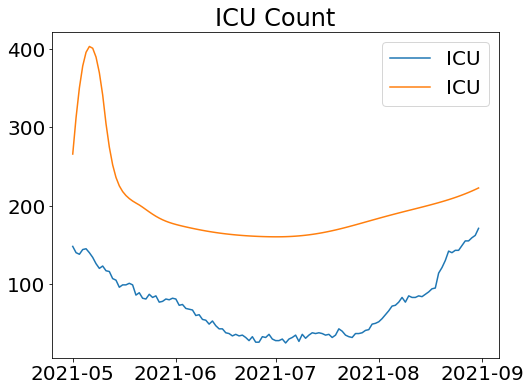

In [19]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_test), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='ICU')
plt.plot(df.loc[train_start:test_end].index.values, preds[0][2], label='ICU')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('ICU Count')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Gen Count')

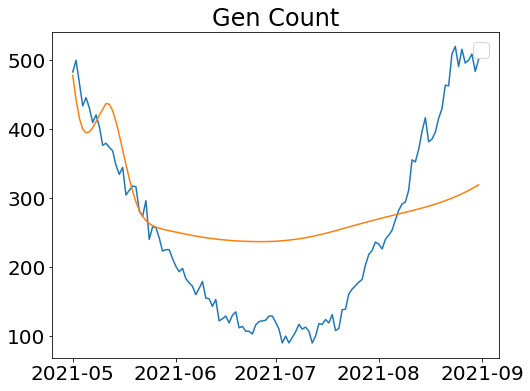

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][0])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Count')

In [ ]:
model.variables

In [ ]:
model._constrain_parameters()

In [ ]:
model._sample_and_reparameterize()

In [ ]:
model.rho_M_params

In [ ]:
model.rho_M_samples_constrained

In [ ]:
!pwd

In [21]:
new_config = model.config.update_from_model(model)

In [ ]:
new_config.to_json("/mnt/c/Users/kheut/Downloads/deriv.json")

In [ ]:
y_train

In [ ]:
model.init_count_G_params

In [ ]:
model.config.init_count_I.value

In [ ]:
new_config = model.config.update_from_model(model)

In [ ]:
new_config.to_json("/mnt/c/Users/kheut/Downloads/fix_after_600.json")

In [ ]:
model.variables

In [ ]:
model.init_count_G_params

In [ ]:
model.variables

In [ ]:
model.init_count_G_samples_constrained[0].numpy().min()

In [ ]:
tfp.bijectors.Softplus.inverse(17/100)

In [24]:
new_config.init_count_I.value

{0: {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=115.948654>,
  'scale': <tf.Tensor: shape=(), dtype=float32, numpy=3.4406927>},
 1: {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=18.30392>,
  'scale': <tf.Tensor: shape=(), dtype=float32, numpy=0.16832918>}}